### Import Libraries

In [1]:
import imblearn
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
import time

from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.pipeline import Pipeline
from scipy import stats
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression

# Database Connection Setup
###########################################################################
from dotenv import load_dotenv
dotenv = load_dotenv()
CONNECTION_STRING = os.getenv("MYSQL_CONNECTION_STRING")
from database import Base
from load import session_engine_from_connection_string
###########################################################################

random_state = 42

### Load Data

In [3]:
# open database session
session, engine = session_engine_from_connection_string(CONNECTION_STRING)
conn = engine.connect()

# SQL command to extract table
sql_query = f"SELECT * FROM classification_data"
data = pd.read_sql(sql_query, session.bind)

# close database session
session.close()
conn.close()

# load data from local directory
# data_directory = os.path.join(os.getcwd(), "data", "ml_data")
# data = pd.read_csv(os.path.join(data_directory, "classification_data.csv"))

'\n# load data from local directory\ndata_directory = os.path.join(os.getcwd(), "data", "ml_data")\ndata = pd.read_csv(os.path.join(data_directory, "classification_data.csv"))\n'

In [4]:
display(data)

,id,playtime,rating,reviews_text_count,added_count,suggestions_count,website,screenshots_count,movies,achievements_count,...,genre_massively_multiplayer,genre_platformer,genre_puzzle,genre_racing,genre_role_playing_games_rpg,genre_shooter,genre_simulation,genre_sports,genre_strategy,genres_count
0,28,18,4,65,13762,583,1,47.0,0,40.0,...,0,0,0,0,0,0,0,0,0,2
1,9639,3,3,0,117,536,0,26.0,0,24.0,...,0,0,0,0,1,0,1,0,1,3
2,9932,1,1,0,577,317,1,6.0,1,36.0,...,0,0,0,0,1,0,0,0,0,3
3,11787,3,3,0,51,297,1,7.0,1,12.0,...,0,0,0,0,0,0,0,0,0,2
4,17327,1,2,1,913,119,1,5.0,1,12.0,...,0,0,0,0,0,0,1,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1564,916515,0,0,0,0,0,0,9.0,0,0.0,...,0,0,0,1,0,0,1,1,0,5
1565,916531,0,0,0,0,0,0,7.0,0,0.0,...,0,0,0,0,0,0,1,0,0,5
1566,917815,0,0,0,0,0,0,11.0,0,0.0,...,0,0,0,0,0,0,1,0,0,1
1567,926923,0,0,0,0,0,1,4.0,0,0.0,...,0,0,1,0,0,0,0,0,0,1


In [5]:
data["rating"].value_counts(sort=False)

4      14
3      41
1       2
2      19
0    1493
Name: rating, dtype: int64

Explanation:

Class 4 - Games with rating 4-5 (~Exceptional)

Class 3 - Games with rating 3-4 (~Recommended)

Class 2 - Games with rating 2-3 (~Meh)

Class 1 - Games with rating 1-2 (~Skip)

Class 0 - Games with no rating

### Detect Outliers

In [6]:
num_col = [
    'playtime', 
    'game_series_count', 
    'additions_count', 
    'parents_count', 
    'suggestions_count',
    'screenshots_count',
    'reddit_count', 
    'twitch_count', 
    'youtube_count', 
    'added_count',
    'reviews_text_count', 
    'achievements_count',
    'platforms_count', 
    'stores_count',
    'genres_count',
]
data_no_outliers = data.copy()
data_no_outliers[num_col] = data[num_col][(np.abs(stats.zscore(data[num_col])) < 3).all(axis=1)]
print(data_no_outliers.shape)

(1569, 66)


No outliers present.

### Train Test Split

In [7]:
x = data.drop(columns=["id","rating"])
y = (data["rating"] > 2).astype(int) # binarize
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=random_state)

### Training

In [15]:
def train(x_train,y_train,model,params):
    
    gridsearchcv = GridSearchCV(model, params, cv=3, scoring='f1_weighted', verbose=True, n_jobs=-1)
    gridsearchcv.fit(x_train, y_train.values.ravel())
    best_model = model.set_params(**gridsearchcv.best_params_).fit(x_train, y_train.values.ravel())
    
    return best_model

steps = [
    ("scaling", ColumnTransformer(transformers=[('standard_scaler',StandardScaler(),num_col)],remainder='passthrough')),
    ('resampling', SMOTEENN(random_state=random_state,enn=EditedNearestNeighbours(sampling_strategy='majority'))),
    ('training', LogisticRegression(random_state=random_state,class_weight='balanced')),
]

model = Pipeline(steps=steps)

params = dict(
    training__C       = [0.001,0.01,0.1,1,10],
    training__solver  = ['lbfgs','liblinear','newton-cg','newton-cholesky','sag','saga'],
)

In [23]:
# train
start = time.time()
best_model = train(x_train,y_train,model,params)
end = time.time()

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/home/chuyanxun/env/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/chuyanxun/env/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/chuyanxun/env/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/chuyanxun/env/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/chuyanxun/env/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm

/home/chuyanxun/env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/chuyanxun/env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/chuyanxun/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/chuyanxun/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfg

In [24]:
# train time
print("Training Runtime:",str(round((end-start),3)) + "s")

Training Runtime: 2.474s


In [ ]:
'''
pickle.dump(best_model["scaling"], open("model/standard_scaler.pkl","wb"))
pickle.dump(best_model["training"], open("model/classification_model.pkl","wb"))
x_train.to_csv("model/x_train.csv",index=False)
x_test.to_csv("model/x_test.csv",index=False)
y_train.to_csv("model/y_train.csv",index=False)
y_test.to_csv("model/y_test.csv",index=False)
'''

### Evaluation

In [5]:
def evaluate(x_test,y_test,name,model,scaler):

    print(model,"\n")
    
    y_pred = model.predict(scaler.transform(x_test))

    scores = {}
    scores["Accuracy"]  = accuracy_score(y_test,y_pred).round(3)
    scores["Precision"] = precision_score(y_test,y_pred,average="weighted").round(3)
    scores["Recall"]    = recall_score(y_test,y_pred,average="weighted").round(3)
    scores["F1"]        = f1_score(y_test,y_pred,average="weighted").round(3)
    scores["ROC AUC"]   = roc_auc_score(y_test,y_pred,average="weighted").round(3)
    scores = {name:scores}
    print(pd.DataFrame(scores))

    cm = confusion_matrix(y_test,y_pred)
    cm_plot = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues_r')
    cm_plot.set_xlabel('Predicted Values')
    cm_plot.set_ylabel('Actual Values')
    plt.show()



name = "Logistic Regression"
loaded_model = pickle.load(open("model/classification_model.pkl", 'rb'))
loaded_scaler = pickle.load(open("model/standard_scaler.pkl", 'rb'))
x_test = pd.read_csv("model/x_test.csv")
y_test = pd.read_csv("model/y_test.csv")

LogisticRegression(C=0.1, class_weight='balanced', random_state=42) 

           Logistic Regression
Accuracy                 0.972
F1                       0.975
Precision                0.978
ROC AUC                  0.901
Recall                   0.972


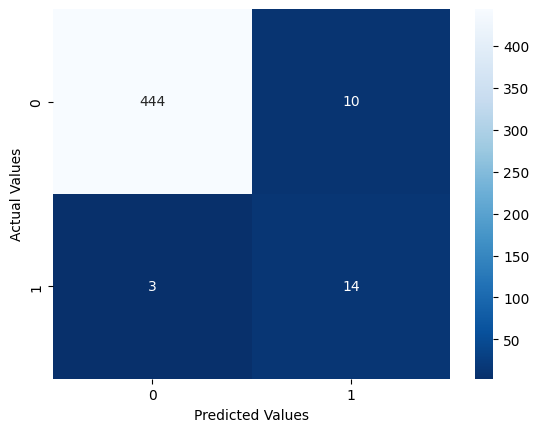

In [6]:
# evaluate
evaluate(x_test,y_test,name,loaded_model,loaded_scaler)

In [9]:
# feature importance
feature_importance = pd.DataFrame(data=x_test.columns, columns=["feature"])
feature_importance["importance"] = pow(math.e, loaded_model.coef_[0]).round(3)
feature_importance = feature_importance.sort_values(by=["importance"], ascending=False)

# top overall features
display(feature_importance.head(10))

,feature,importance
7,achievements_count,7.198
0,playtime,3.145
10,twitch_count,2.610
1,reviews_text_count,2.270
30,platform_playstation5,2.077
41,store_steam,2.034
9,reddit_count,1.973
13,additions_count,1.864
56,genre_puzzle,1.618
45,genre_adventure,1.567


In [10]:
# top game features
display(feature_importance[~feature_importance["feature"].str.startswith(('platform','store','genre'))].head(10))

,feature,importance
7,achievements_count,7.198
0,playtime,3.145
10,twitch_count,2.610
1,reviews_text_count,2.270
9,reddit_count,1.973
13,additions_count,1.864
15,tba,1.396
14,game_series_count,1.331
6,movies,1.273
8,reddit_url,1.260


In [11]:
# top platforms
display(feature_importance[feature_importance["feature"].str.startswith('platform')].head(10))

,feature,importance
30,platform_playstation5,2.077
31,platform_ps_vita,1.108
21,platform_android,1.075
33,platform_xbox_series_x,1.035
34,platforms_count,1.006
28,platform_pc,1.000
29,platform_playstation4,1.000
32,platform_xbox_one,0.999
23,platform_linux,0.998
22,platform_ios,0.944


In [12]:
# top stores
display(feature_importance[feature_importance["feature"].str.startswith('store')].head(10))

,feature,importance
41,store_steam,2.034
39,store_nintendo,1.259
43,stores_count,1.153
35,store_apple_appstore,1.124
36,store_epic_games,1.063
42,store_xbox_store,1.005
38,store_google_play,0.996
40,store_playstation_store,0.885
37,store_gog,0.540


In [13]:
# top genres
display(feature_importance[feature_importance["feature"].str.startswith('genre')].head(10))

,feature,importance
56,genre_puzzle,1.618
45,genre_adventure,1.567
61,genre_sports,1.420
46,genre_arcade,1.406
57,genre_racing,1.370
54,genre_massively_multiplayer,1.183
44,genre_action,1.032
60,genre_simulation,1.007
51,genre_family,0.999
52,genre_fighting,0.981
